In [1]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
import pandas as pd


# Reading train and test csv

In [3]:
train_text = "https://drive.google.com/file/d/1IDZ7rX_-76frncs4Qsa6SNLGoB3TP3LK/view?usp=sharing" #shared_tasks_posts
train_label = "https://drive.google.com/file/d/1JKptOIQ9d6Cx3NiVhcphk1dWe5z5XLMv/view?usp=sharing" #crowd_train

test_text = "https://drive.google.com/file/d/1b8rMyhVKtLyutmp5WskFUtavLFf-PvWM/view?usp=sharing" #hared_tasks_posts_test
test_label = "https://drive.google.com/file/d/1_az1vI--qAcULTkYNjAHzF1w7rUoP4-k/view?usp=sharing" #crowd_test

def download_file(link, save_as):
    file_id = link.split("/")[-2]  # Extract the file ID from the link
    downloaded = drive.CreateFile({'id': file_id})  # Create a file object
    downloaded.GetContentFile(save_as)  # Download the file and save it locally
    print(f"Downloaded: {save_as}")

download_file(train_text, "train_text.csv")
download_file(train_label, "train_label.csv")
download_file(test_text, "test_text.csv")
download_file(test_label, "test_label.csv")

Downloaded: train_text.csv
Downloaded: train_label.csv
Downloaded: test_text.csv
Downloaded: test_label.csv


In [6]:
train_text = pd.read_csv("train_text.csv")
train_text.head(5)

post_id  user_id   timestamp        subreddit  \
0   wfimt    22002  1342075703     GetMotivated   
1  1bsqv3    22002  1365261010  leagueoflegends   
2  1buqml    22002  1365345637        seduction   
3  1dr0xf    22002  1367787358  leagueoflegends   
4  1e0noi    22002  1368125785  leagueoflegends   

                                          post_title  \
0                                  [real] motivation   
1  simple question about transfering acc to anoth...   
2    _PERSON_ up ever (crosspost from r/GetMotivated   
3             simple question: Did you get unnbaned?   
4         I can't win. Why... and it's noy my fault.   

                                           post_body  
0  This is my first post on reddit. Some time ago...  
1  Hi.. What will happen with my ranked rating? I...  
2                                                NaN  
3  Hi. Simple question. Did you get unban from a ...  
4  Hi... Am playing at Eu west... am diamond 5 ri...

In [7]:
train_label = pd.read_csv("train_label.csv")
train_label.head(5)

user_id label
0    40130     a
1    19368     a
2    20841     a
3     8720     a
4    32730     a

In [8]:
test_text = pd.read_csv("test_text.csv")
test_text.head(5)

post_id  user_id   timestamp     subreddit  \
0   lqc87    22411  1319673820  SuicideWatch   
1   lqleq    22411  1319688687     AskReddit   
2   lxaor    22411  1320205091  SuicideWatch   
3   m1x5n    22411  1320540286        videos   
4   m47u6    22411  1320714594     theoffice   

                                          post_title  \
0   Is it "Stronger" to kill yourself or stay alive?   
1                                Is it me or my job?   
2  Not entirely sure where this belongs, But you ...   
3            God is great and we are shit (_PERSON_)   
4                   I think we see to more of Creed.   

                                           post_body  
0  I mean really, I think about it, I don't want ...  
1  I'm not sure if this is in the right place but...  
2  So where to begin... So I have facets of my li...  
3                                                NaN  
4  Seriously he needs more airtime, cause he is c...

In [9]:
test_label = pd.read_csv("test_label.csv")
test_label.head(5)

user_id raw_label
0    35972         a
1     6789         a
2    30606         a
3    50962         a
4    49555         a

In [10]:
# Display unique user_ids
unique_user_ids = train_text['user_id'].unique()

# Print the number of unique user_ids and the user_ids themselves
print(f"Number of unique user_ids: {len(unique_user_ids)}")
print("Unique user_ids:", unique_user_ids)


Number of unique user_ids: 21518
Unique user_ids: [ 22002  22006  22014 ... -39971 -39973 -39990]


# Only use positive user_ids

In [11]:
# Keep only positive user ids
train_text = train_text[train_text['user_id'] > 0]
train_label = train_label[train_label['user_id'] > 0]
test_text = test_text[test_text['user_id'] > 0]
test_label = test_label[test_label['user_id'] > 0]


In [12]:
# find unique user_id in train_labels
unique_train_id = train_label['user_id'].unique()
print(len(unique_train_id))

# filter train_text by unique user_id
train_text = train_text[train_text['user_id'].isin(unique_train_id)]
print(len(train_text))

496
31553


In [13]:
# find unique user_id in test_labels
unique_test_id = test_label['user_id'].unique()
print(len(unique_test_id))

# filter test_text by unique user_id
test_text = test_text[test_text['user_id'].isin(unique_test_id)]
print(len(test_text))

125
9610


In [14]:
# checking shape of all dfs
print(train_text.shape)
print(test_text.shape)
print(train_label.shape)
print(test_label.shape)

(31553, 6)
(9610, 6)
(496, 2)
(125, 2)


In [15]:
def process_full_df(df):
    def concatenate_pairwise(series1, series2):
        # Pairwise concatenation with fallback to keep available text if the other is missing
        combined = [
            f"{str(title)} {str(body)}".strip()  # Strip removes extra spaces if one is empty
            if pd.notna(title) and pd.notna(body)
            else str(title) if pd.notna(title)
            else str(body) if pd.notna(body)
            else ""
            for title, body in zip(series1, series2)
        ]
        # Join all unique pairwise concatenations
        return ' '.join(pd.Series(combined).drop_duplicates())

    # Group by user_id and apply the pairwise concatenation
    concatenated_text = (
        df.groupby('user_id', group_keys=False)  # Ensure group keys are not passed
        [['post_title', 'post_body']]           # Explicitly select columns
        .apply(lambda group: concatenate_pairwise(group['post_title'], group['post_body']))
        .reset_index(name='combined_text')
    )

    return concatenated_text

# Process train and test datasets
train_text = process_full_df(train_text)
test_text = process_full_df(test_text)


In [16]:
# checking shape of all dfs
print(train_text.shape)
print(test_text.shape)
print(train_label.shape)
print(test_label.shape)

(496, 2)
(125, 2)
(496, 2)
(125, 2)


In [17]:
def add_labels(text_df, label_df, label_column_name):
    # Merge the text dataframe with the labels dataframe on user_id
    return text_df.merge(label_df[['user_id', label_column_name]], on='user_id', how='left')

# Add labels to train and test datasets
train_text = add_labels(train_text, train_label, 'label')
test_text = add_labels(test_text, test_label, 'raw_label')

# Rename the label columns for consistency (optional)
train_text.rename(columns={'label': 'label'}, inplace=True)
test_text.rename(columns={'raw_label': 'label'}, inplace=True)

# Ensure final column order (optional)
train_text = train_text[['user_id', 'combined_text', 'label']]
test_text = test_text[['user_id', 'combined_text', 'label']]

In [18]:
train_text.head()

user_id                                      combined_text label
0       16  Every fucking time at work. The saddest part i...     d
1       56  Looking for a faction. I am playing on the tes...     c
2      137  What my golf ball was thinking today... China ...     c
3      152  Browsing the twitter during the political deba...     a
4      370  What about the sane ones? (this was posted fro...     c

In [19]:
test_text.head()

user_id                                      combined_text label
0      195  My spoiled baby, _PERSON_ [Reginald H.W. Spald...     d
1      450  My apple has a heart. First time poster, long ...     d
2      979  [H] Riot Singed, _PERSON_, _PERSON_, _PERSON_,...     a
3     1073  I can't my whole body is shaking while I write...     d
4     1642  Trans people of reddit, any advice for a frien...     a

#Converting string labels to numerical labels

In [20]:
def label_num(label):
  num = None
  if str(label) == "a":
    num = 0
  elif str(label) == "b":
    num = 1
  elif str(label) == "c":
    num = 2
  elif str(label) == "d":
    num = 3
  return num

In [21]:
# convert labels a, b, c, d to 0, 1, 2, 3

# Add sentence vectors to DataFrame
train_text['int_label'] = train_text['label'].apply(lambda x: label_num(x))

# Add sentence vectors to DataFrame
test_text['int_label'] = test_text['label'].apply(lambda x: label_num(x))

# Preprocessing Cleaning, remove punctuation, digits and missing values, and lowercase

In [22]:
# Ensure 'post_title_concatenated' and 'post_body_concatenated' are treated as strings, handle missing values, and convert to lowercase
train_text['combined_text'] = train_text['combined_text'].fillna('').astype(str).str.lower()
test_text['combined_text'] = test_text['combined_text'].fillna('').astype(str).str.lower()


In [23]:
# Remove punctuation
train_text['combined_text'] = train_text['combined_text'].replace(to_replace=r'[^\w\s]', value='', regex=True)
test_text['combined_text'] = test_text['combined_text'].replace(to_replace=r'[^\w\s]', value='', regex=True)

In [24]:
# Remove digits
train_text['combined_text'] = train_text['combined_text'].replace(to_replace=r'\d', value='', regex=True)
test_text['combined_text'] = test_text['combined_text'].replace(to_replace=r'\d', value='', regex=True)

### Using NLTK to remove STOP words

In [25]:
import nltk
nltk.data.path.append('/root/nltk_data')


In [26]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
train_text['combined_text'] = train_text['combined_text'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)
test_text['combined_text'] = test_text['combined_text'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


stopwords removed, lemmatization not done

In [27]:
pd.set_option('display.max_colwidth', None)  # Display full content of cells
train_text.head(1)

user_id  \
0       16   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

### Using NLTK to for whitespace tokenization

In [28]:
# We going with this one because it's faster
from tokenizers.pre_tokenizers import Whitespace

# Initialize the pre-tokenizer
pre_tokenizer = Whitespace()

# Function to tokenize and extract tokens
def tokenize_text(text):
    return [token for token, _ in pre_tokenizer.pre_tokenize_str(text)]

# Apply tokenization to the DataFrame
train_text['combined_text_tokenized'] = train_text['combined_text'].apply(tokenize_text)
test_text['combined_text_tokenized'] = test_text['combined_text'].apply(tokenize_text)

### Lemmatizing

In [29]:
# import and download packages
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:

lemmatizer = WordNetLemmatizer()

# map NLTK POS tags to wordnet POS tags
def get_wordnet_pos(tag):
    tag = tag[0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


In [31]:
# apply lemmatization with POS tagging to train title/body
train_text['combined_text_tokenized'] = train_text['combined_text_tokenized'].apply(
    lambda x: [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in pos_tag(x)
    ]
)


In [32]:
# apply lemmatization with POS tagging to test title/body
test_text['combined_text_tokenized'] = test_text['combined_text_tokenized'].apply(
    lambda x: [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in pos_tag(x)
    ]
)



In [33]:
train_text.head(3)

user_id  \
0       16   
1       56   
2      137   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [34]:
train_text.count()

user_id                    496
combined_text              496
label                      496
int_label                  496
combined_text_tokenized    496
dtype: int64

In [35]:
test_text.count()

user_id                    125
combined_text              125
label                      125
int_label                  125
combined_text_tokenized    125
dtype: int64

# Using Word2Vec

In [36]:
from gensim.models import Word2Vec
import numpy as np

# Combine tokenized text from train and test datasets
train_tokenized_text = train_text['combined_text_tokenized'].tolist()

test_tokenized_text = test_text['combined_text_tokenized'].tolist()


# Train Word2Vec model
word2vec_model_train = Word2Vec(sentences=train_tokenized_text, vector_size=300, window=5, min_count=1, workers=4)

# Test Word2Vec model
word2vec_model_test = Word2Vec(sentences=test_tokenized_text, vector_size=300, window=5, min_count=1, workers=4)


# Function to compute sentence vector
def sentence_to_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Add sentence vectors to DataFrame
train_text['combined_text_tokenized_vector'] = train_text['combined_text_tokenized'].apply(lambda x: sentence_to_vector(x, word2vec_model_train))

test_text['combined_text_tokenized_vector'] = test_text['combined_text_tokenized'].apply(lambda x: sentence_to_vector(x, word2vec_model_test))



In [37]:
train_text.head(3)

user_id  \
0       16   
1       56   
2      137   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

# Using Empath library

In [38]:
#Empath Lexical Categories
!pip install empath

from empath import Empath

# Initialize Empath analyzer
lexicon = Empath()

# Function to calculate Empath category frequencies
def calculate_empath_categories(tokens):
    categories = lexicon.analyze(tokens, categories=["positive_emotion", "negative_emotion"], normalize=True)
    return categories


In [39]:
# Compute Empath categories for title and body
train_text['combined_text_empath'] = train_text['combined_text'].apply(calculate_empath_categories)

test_text['combined_text_empath'] = test_text['combined_text'].apply(calculate_empath_categories)


In [40]:
train_text.head(3)

user_id  \
0       16   
1       56   
2      137   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

# Using Vadar Sentiment Analysis

In [41]:
#https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
!pip install vaderSentiment

# import SentimentIntensityAnalyzer class
# from vaderSentiment.vaderSentiment module.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):

  # Create a SentimentIntensityAnalyzer object.
  sid_obj = SentimentIntensityAnalyzer()

  # polarity_scores method of SentimentIntensityAnalyzer
  # object gives a sentiment dictionary.
  # which contains pos, neg, neu, and compound scores.
  sentiment_dict = sid_obj.polarity_scores(sentence)

  # print("Overall sentiment dictionary is : ", sentiment_dict)
  # print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
  # print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
  # print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
  # print("Sentence Overall Rated As", end = " ")

  # decide sentiment as positive, negative and neutral
  # if sentiment_dict['compound'] >= 0.05 :
  #   print("Positive")
  # elif sentiment_dict['compound'] <= - 0.05 :
  #   print("Negative")
  # else :
  #   print("Neutral")

  return sentiment_dict

#vadar = sentiment_scores(["This movie was so sad, it made me cry. I hate this project!!!"])
#print(vadar)

In [42]:
# Add sentence vectors to DataFrame
train_text['combined_text_tokenized_vadar'] = train_text['combined_text_tokenized'].apply(lambda x: sentiment_scores(x))


In [43]:
test_text['combined_text_tokenized_vadar'] = test_text['combined_text_tokenized'].apply(lambda x: sentiment_scores(x))


In [44]:
train_text.head(3)

user_id  \
0       16   
1       56   
2      137   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

# Convert dataframe to torch.utils.data.dataset.Dataset

In [45]:
df_train = train_text.copy(deep=False)
df_test = test_text.copy(deep=False)

In [46]:
df_train.columns

Index(['user_id', 'combined_text', 'label', 'int_label',
       'combined_text_tokenized', 'combined_text_tokenized_vector',
       'combined_text_empath', 'combined_text_tokenized_vadar'],
      dtype='object')

In [47]:
df_train.drop(["combined_text_tokenized_vector"
  , "combined_text_empath"
  , "combined_text_tokenized_vadar"
], axis=1, inplace=True)

df_test.drop(["combined_text_tokenized_vector"
  , "combined_text_empath"
  , "combined_text_tokenized_vadar"
], axis=1, inplace=True)


In [48]:
df_train.columns

Index(['user_id', 'combined_text', 'label', 'int_label',
       'combined_text_tokenized'],
      dtype='object')

#**Multinomial Naive Bayes**

>



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Training Accuracy: 0.9742
Classification Report for Training Data (Naive Bayes):
              precision    recall  f1-score   support

           a       0.97      0.99      0.98       162
           b       0.99      0.96      0.98       168
           c       0.98      0.98      0.98       167
           d       0.96      0.98      0.97       162

    accuracy                           0.97       659
   macro avg       0.97      0.97      0.97       659
weighted avg       0.97      0.97      0.97       659



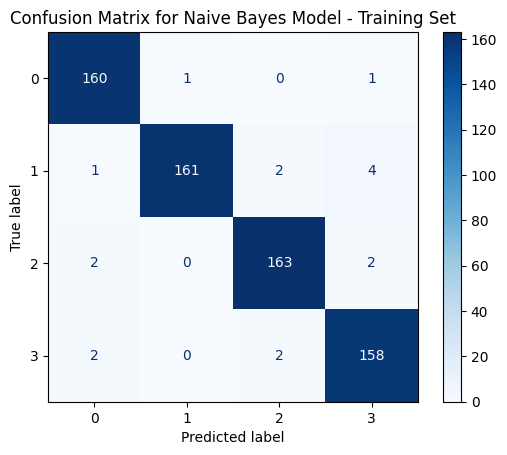

In [49]:
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Use TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # You can adjust max_features based on your data
X_train = vectorizer.fit_transform(df_train['combined_text'])
X_test = vectorizer.transform(df_test['combined_text'])

# Assuming the labels are in 'train_label' and 'test_label' DataFrames
y_train = train_label['label']  # Replace 'label' with the actual label column name
y_test = test_label['raw_label']  # Replace 'label' with the actual label column name

# Apply SMOTE to the training set to balance class distribution
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Split the training data further into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

# Train Naive Bayes on the balanced dataset
MNB_model = MultinomialNB(alpha=0.1)
MNB_model.fit(X_train_resampled, y_train_resampled)

# Predict on the training set, validation set, and test set
y_train_pred = MNB_model.predict(X_train_split)
y_val_pred = MNB_model.predict(X_val_split)
y_test_pred = MNB_model.predict(X_test)

# Evaluate the model
train_accuracy = accuracy_score(y_train_split, y_train_pred)
val_accuracy = accuracy_score(y_val_split, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print training accuracy
print(f"Training Accuracy: {train_accuracy:.4f}")

# Classification report for training data
print("Classification Report for Training Data (Naive Bayes):")
print(classification_report(y_train_split, y_train_pred))

# Confusion Matrix for Training Data
cm_train = confusion_matrix(y_train_split, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(cmap=plt.cm.Blues)

# Add title for the training set confusion matrix
plt.title("Confusion Matrix for Naive Bayes Model - Training Set")
plt.show()

Validation Accuracy: 0.9515
Classification Report for Validation Data (Naive Bayes):
              precision    recall  f1-score   support

           a       0.98      0.93      0.95        44
           b       0.95      0.97      0.96        38
           c       0.97      0.92      0.95        39
           d       0.91      0.98      0.95        44

    accuracy                           0.95       165
   macro avg       0.95      0.95      0.95       165
weighted avg       0.95      0.95      0.95       165



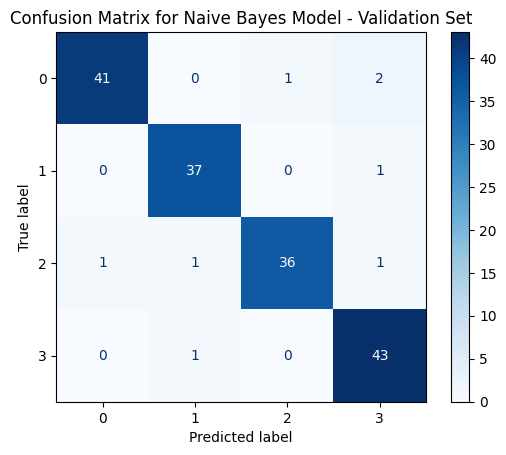

In [50]:
# Print validation accuracy
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Classification report for validation data
print("Classification Report for Validation Data (Naive Bayes):")
print(classification_report(y_val_split, y_val_pred))

# Confusion Matrix for Validation Data
cm_val = confusion_matrix(y_val_split, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot(cmap=plt.cm.Blues)

# Add title for the validation set confusion matrix
plt.title("Confusion Matrix for Naive Bayes Model - Validation Set")
plt.show()

Test Accuracy: 0.3680
Classification Report for Test Data (Naive Bayes):
              precision    recall  f1-score   support

           a       0.20      0.19      0.19        32
           b       1.00      0.15      0.27        13
           c       0.28      0.32      0.30        28
           d       0.48      0.56      0.51        52

    accuracy                           0.37       125
   macro avg       0.49      0.31      0.32       125
weighted avg       0.42      0.37      0.36       125



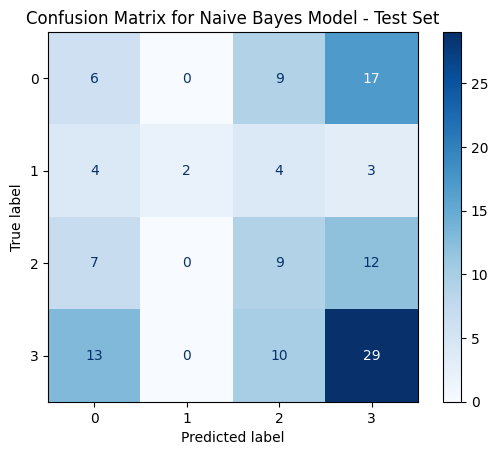

In [51]:
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report for test data
print("Classification Report for Test Data (Naive Bayes):")
print(classification_report(y_test, y_test_pred))

y_pred = MNB_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

# Add a title
plt.title("Confusion Matrix for Naive Bayes Model - Test Set")

# Show the plot
plt.show()


**Classification on test dataset using Multinomial Naive Bayes**

In [52]:
# Randomly select 5 samples from your test dataset
sample_texts = df_test['combined_text'].sample(5).values
print("Sample Texts:")
print(sample_texts)

Sample Texts:
['need advice fellow ents zippo good lighting bowls got one present tolerance break unable test main concern zippos wind proof flame wont sucked bowl watched child hood favourite today didnt realize guy total ent ranarchisms views canadian military including recent move aggressive role afghanistan canadian military done lot peace keeping helping local communities believe return stand point _person_ leaves joining anything know video made anarchism anything would correct video time bomb work mean joint bowl work science magic request copy blank diary cover advanced potions hbp looking surprise close friends birthday would mean world someone found one sale gory japanese defiantly made say wtf would patronus feel mine would patronus mom best friend ride horses im using logic _person_s stag thats fathers wanted new pope hate happens xpost r adviceanimals alliance rpickles brothers sisters side yellow curved demons zucchini pickle kin proud green straight produce join us surro

In [53]:
# Transform the selected sample texts using the same vectorizer
X_sample = vectorizer.transform(sample_texts)

# Predict the labels for the selected sample texts
predictions = MNB_model.predict(X_sample)

# Get the corresponding true labels for the selected sample texts
true_labels = y_test.loc[test_text['combined_text'].isin(sample_texts)].values

# Display both predicted and true labels for each sample
print("\nPredictions and True Labels for Sample Texts:")
for i, sample in enumerate(sample_texts):
    print(f"Sample {i + 1}: {sample}")
    print(f"Predicted Label: {predictions[i]}")
    print(f"True Label: {true_labels[i]}")
    print("="*50)


Predictions and True Labels for Sample Texts:
Sample 1: need advice fellow ents zippo good lighting bowls got one present tolerance break unable test main concern zippos wind proof flame wont sucked bowl watched child hood favourite today didnt realize guy total ent ranarchisms views canadian military including recent move aggressive role afghanistan canadian military done lot peace keeping helping local communities believe return stand point _person_ leaves joining anything know video made anarchism anything would correct video time bomb work mean joint bowl work science magic request copy blank diary cover advanced potions hbp looking surprise close friends birthday would mean world someone found one sale gory japanese defiantly made say wtf would patronus feel mine would patronus mom best friend ride horses im using logic _person_s stag thats fathers wanted new pope hate happens xpost r adviceanimals alliance rpickles brothers sisters side yellow curved demons zucchini pickle kin p

## **Support Vector Machine (SVM)**

In [54]:
# for training set
# make separate columns for positive and negative empath scores
emotion_features = pd.json_normalize(train_text['combined_text_empath'])

# concatenate new features with the original df
train_text = pd.concat([train_text, emotion_features], axis=1)

# for testing set
# make separate columns for positive and negative empath scores
emotion_features = pd.json_normalize(test_text['combined_text_empath'])

# concatenate new features with the original df
test_text = pd.concat([test_text, emotion_features], axis=1)

In [55]:
# using SMOTE
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

sentence_vectors = np.vstack(train_text['combined_text_tokenized_vector'].values)
emotion_features = train_text[['positive_emotion', 'negative_emotion']].values

# combine sentence vector and emotion features
X = np.hstack([sentence_vectors, emotion_features])
y = train_text['int_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# hyperparam tuning with balanced classes
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(
    SVC(decision_function_shape='ovo'),
    param_grid,
    cv=5,
    scoring='f1_macro'
)

grid_search.fit(X_train_scaled, y_train_resampled)
best_svm = grid_search.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [59]:
from collections import Counter

# Print the class distribution in the original training set
print("Original y_train distribution:", Counter(y_train))

# Print the class distribution in the resampled training set
print("Resampled y_train distribution:", Counter(y_train_resampled))

Original y_train distribution: Counter({3: 161, 0: 105, 2: 88, 1: 42})
Resampled y_train distribution: Counter({3: 161, 2: 161, 0: 161, 1: 161})


In [60]:
# print out the params for the best model
print(best_svm.get_params())

{'C': 100, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [61]:
# predict on validation set
y_pred = best_svm.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.45

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.55      0.52        22
           1       0.20      0.25      0.22         8
           2       0.38      0.36      0.37        25
           3       0.52      0.49      0.51        45

    accuracy                           0.45       100
   macro avg       0.40      0.41      0.40       100
weighted avg       0.46      0.45      0.45       100



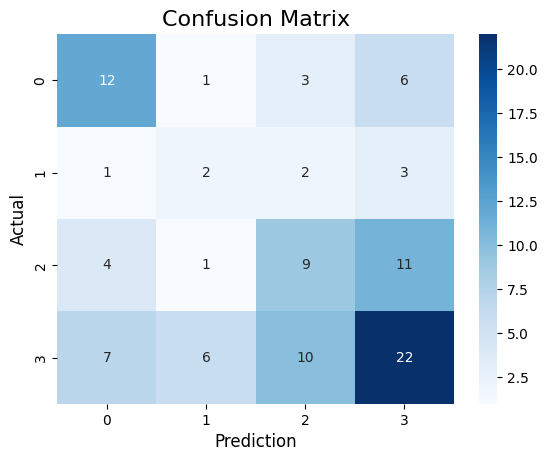

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
plt.ylabel('Actual',fontsize=12)
plt.xlabel('Prediction',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

Predicting on the test set

In [63]:
# test smote attempt

# get sentence vectors for test set
sentence_vectors = np.vstack(test_text['combined_text_tokenized_vector'].values)

# get emotion features
emotion_features = test_text[['positive_emotion', 'negative_emotion']].values

# combine features
X_test = np.hstack([sentence_vectors, emotion_features])

# get labels
y_test = test_text['int_label']

# scale the test features using the same scaler used during training
X_test_scaled = scaler.transform(X_test)

In [64]:
# predict on test set
y_pred = best_svm.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.416

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        28
           3       0.42      1.00      0.59        52

    accuracy                           0.42       125
   macro avg       0.10      0.25      0.15       125
weighted avg       0.17      0.42      0.24       125



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


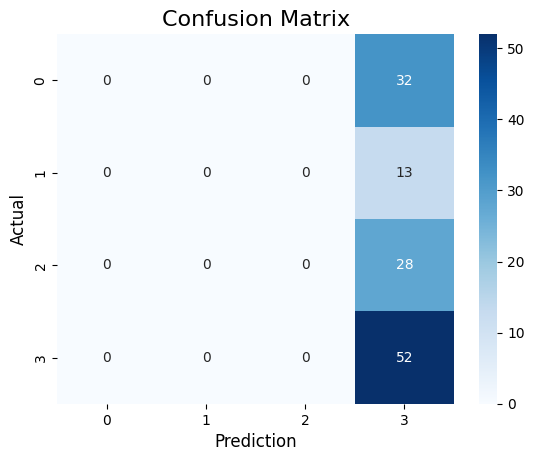

In [65]:
# calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
plt.ylabel('Actual',fontsize=12)
plt.xlabel('Prediction',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

##**LSTM**

In [66]:
# Find the 20 longest sentences by word count
longest_sentences = sorted(train_text['combined_text'], key=lambda x: len(x.split()), reverse=True)[:20]

# Print the 20 longest sentences and their word counts
for i, sentence in enumerate(longest_sentences, start=1):
    word_count = len(sentence.split())
    print(f"Sentence {i}:")
    print(f"Sentence: {sentence}")
    print(f"Word count: {word_count}")
    print("="*50)


Sentence 1:
Sentence: know _person_ game steam thats sale right worth much hours time best fight fighting game ever section prejudice announced early never excited game announcement radiant _person_ coming _person_ dae think journeyman project whenever someone brings tsa someone recommend mind blowing game beat one sitting overnight decided im gonna start thing every year new years day day depending whatever im day first game play year one play perfect way one sitting interruptions lights etc etcthe game played new yearss indigo prophecy aka _person_ looking back game probably isnt good played way immersed game didnt even question anything weird stupid going game way youre dreaming something crazy experience came one best games least experiences ive played beat hours without stopping want thoseso game play preferably one sitting blow mind like steam game free game hl mod maybe also got ps _person_ open gamecube gamesedit probably mentioned games playedportal ive beaten around times fir

In [67]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

# 1. Data Preprocessing
MAX_LENGTH = 10000
EMBEDDING_DIM = 300  # Assuming word2vec embeddings have dimension 300

# Padding the tokenized word sequences
train_sequences = train_text['combined_text_tokenized_vector']
test_sequences = test_text['combined_text_tokenized_vector']

train_text_padded = pad_sequences(
    train_sequences, maxlen=MAX_LENGTH, padding='post', truncating='pre'
)
test_text_padded = pad_sequences(
    test_sequences, maxlen=MAX_LENGTH, padding='post', truncating='pre'
)

# Use the `int_label` column directly for the target variable
train_labels = to_categorical(train_text['int_label'])  # One-hot encode the integer labels
test_labels = to_categorical(test_text['int_label'])    # One-hot encode the integer labels

# 2. Train-Validation Split (Stratified)
X_train, X_val, y_train, y_val = train_test_split(
    train_text_padded, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weights = dict(enumerate(class_weights))

# 3. Build the LSTM Model
model = Sequential()
model.add(Embedding(input_dim=len(train_text_padded),
                    output_dim=EMBEDDING_DIM,
                    trainable=False))  # Set trainable to False to use pre-trained embeddings

model.add(SpatialDropout1D(0.3))  # Dropout for regularization
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))  # LSTM layer with dropout
model.add(Dense(64, activation='relu'))  # Additional dense layer
model.add(Dense(len(train_labels[0]), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=3,  # Stop after 3 epochs of no improvement
    restore_best_weights=True,  # Restore weights from the best epoch
    mode='max'  # Maximize validation accuracy
)

# 4. Train the Model
batch_size = 64
epochs = 10

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# 5. Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_text_padded, test_labels)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 178s 24s/step - accuracy: 0.2023 - loss: 1.4061 - val_accuracy: 0.1000 - val_loss: 1.3894
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 196s 24s/step - accuracy: 0.2645 - loss: 1.3544 - val_accuracy: 0.2600 - val_loss: 1.3698
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 159s 23s/step - accuracy: 0.2819 - loss: 1.3931 - val_accuracy: 0.2600 - val_loss: 1.3669
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 207s 24s/step - accuracy: 0.2842 - loss: 1.3977 - val_accuracy: 0.2300 - val_loss: 1.3694
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 208s 25s/step - accuracy: 0.3139 - loss: 1.3959 - val_accuracy: 0.4100 - val_loss: 1.3721
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 198s 24s/step - accuracy: 0.3431 - loss: 1.4013 - val_accuracy: 0.4100 - val_loss: 1.3686
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 212s 25s/step - accuracy: 0.3931 - loss: 1.4042 - val_accuracy: 0.4100 - val_loss: 1.3665
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 201s 25s/step - accuracy: 0.3837 - loss: 1.3760 - val_accuracy: 0.4100 - val_loss:

In [68]:
from sklearn.metrics import classification_report, f1_score

# Predict on the validation set
y_val_pred_probs = model.predict(X_val)  # Predict probabilities for the validation set
y_val_pred = y_val_pred_probs.argmax(axis=1)  # Get the predicted class for each sample
y_val_true = y_val.argmax(axis=1)  # Convert one-hot encoded true labels to class indices

# Calculate the F1 score for the validation set
val_f1 = f1_score(y_val_true, y_val_pred, average='weighted')  # Weighted average accounts for class imbalance
print(f"Validation F1 Score (Weighted): {val_f1}")

# Generate a detailed classification report
val_classification_report = classification_report(
    y_val_true, y_val_pred, target_names=[str(label) for label in np.unique(y_val_true)]
)
print("Validation Classification Report:")
print(val_classification_report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 10s/step
Validation F1 Score (Weighted): 0.23843971631205674
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        23
           3       0.41      1.00      0.58        41

    accuracy                           0.41       100
   macro avg       0.10      0.25      0.15       100
weighted avg       0.17      0.41      0.24       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.4101 - loss: 1.3727
Test Loss: 1.3720530271530151, Test Accuracy: 0.41600000858306885


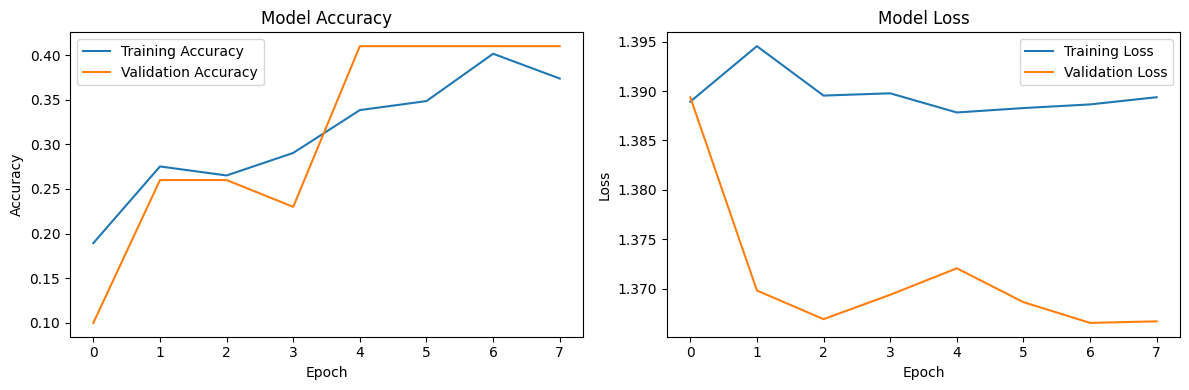

In [69]:
test_loss, test_accuracy = model.evaluate(test_text_padded, test_labels)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Optional: Visualize training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [70]:
from sklearn.metrics import classification_report, f1_score

# Predict on the test set
y_pred_probs = model.predict(test_text_padded)  # Predict probabilities
y_pred = y_pred_probs.argmax(axis=1)  # Get the predicted class for each sample
y_true = test_text['int_label']

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')  # Weighted average accounts for class imbalance
print(f"F1 Score (Weighted): {f1}")

# Detailed classification report
# Replace `label_encoder.classes_` with the numeric class names
class_names = [str(label) for label in np.unique(y_true)]  # Use integer class labels as names
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)



4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 11s/step
F1 Score (Weighted): 0.24442937853107347
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        28
           3       0.42      1.00      0.59        52

    accuracy                           0.42       125
   macro avg       0.10      0.25      0.15       125
weighted avg       0.17      0.42      0.24       125



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


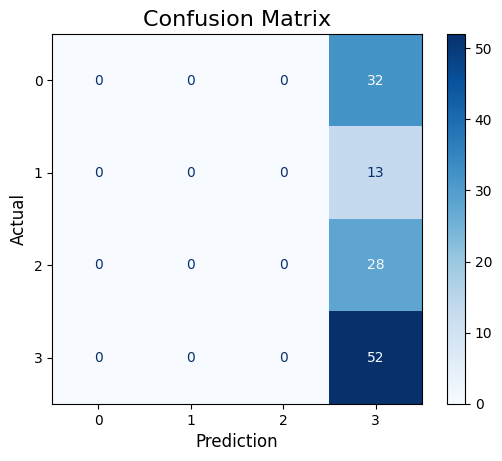

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' ensures integer formatting

plt.ylabel('Actual',fontsize=12)
plt.xlabel('Prediction',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step


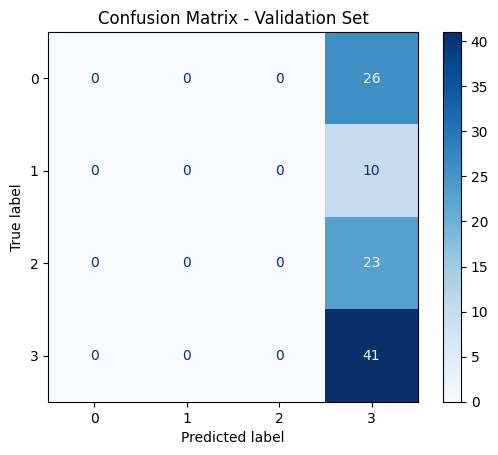

In [72]:
# Predict on the validation set
y_val_pred_probs = model.predict(X_val)  # Predict probabilities for validation set
y_val_pred = y_val_pred_probs.argmax(axis=1)  # Get the predicted class for each sample in the validation set
y_val_true = np.argmax(y_val, axis=1)  # Convert one-hot encoded validation labels back to class indices

# Create the confusion matrix for the validation set
conf_matrix_val = confusion_matrix(y_val_true, y_val_pred)

# Display the confusion matrix for the validation set
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_val, display_labels=class_names)
disp_val.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' ensures integer formatting

plt.title("Confusion Matrix - Validation Set")
plt.show()



## **Distilbert**

In [73]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score

In [74]:
!pip install transformers datasets torch scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [75]:
# Check class distribution for training and validation sets
from sklearn.model_selection import train_test_split

# Assuming train_text is already a pandas DataFrame
# Split into training and validation sets
train_text, val_text = train_test_split(
    df_train,
    test_size=0.2,  # 20% for validation
    stratify=df_train['label'],  # Preserve class distribution
    random_state=42  # For reproducibility
)

# Print class distributions to verify
print("Training class distribution:\n", train_text['label'].value_counts())
print("Validation class distribution:\n", val_text['label'].value_counts())
print("Test class distribution:\n", df_test['label'].value_counts())

Training class distribution:
 label
d    165
a    101
c     90
b     40
Name: count, dtype: int64
Validation class distribution:
 label
d    41
a    26
c    23
b    10
Name: count, dtype: int64
Test class distribution:
 label
d    52
a    32
c    28
b    13
Name: count, dtype: int64


In [76]:
# Convert labels from A, B, C, D to numerical values
label_encoder = LabelEncoder()
train_text['label'] = label_encoder.fit_transform(train_text['label'])
val_text['label'] = label_encoder.transform(val_text['label'])
df_test['label'] = label_encoder.transform(df_test['label'])


# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_text['label']), y=train_text['label'])
class_weight_dict = dict(zip(np.unique(train_text['label']), class_weights))

# Print class weights
print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.9801980198019802, 1: 2.475, 2: 1.1, 3: 0.6}


In [77]:
# Tokenize the text using DistilBERT's tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples['combined_text'], padding=True, truncation=True)

# Tokenize the training and validation datasets
train_encodings = tokenizer(list(train_text['combined_text']), truncation=True, padding=True)
val_encodings = tokenizer(list(val_text['combined_text']), truncation=True, padding=True)

test_encodings = tokenizer(list(df_test['combined_text']), truncation=True, padding=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [78]:
# Create a custom Dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create the training and validation datasets
train_dataset = TextDataset(train_encodings, train_text['label'].values)
val_dataset = TextDataset(val_encodings, val_text['label'].values)
test_dataset = TextDataset(test_encodings, df_test['label'].values)


In [79]:
# Load DistilBERT for sequence classification
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(np.unique(train_text['label'])))

# Class weights on CPU (No need to move them to GPU)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float16)

# Set the loss function for the model with class weights
loss_fn = CrossEntropyLoss(weight=class_weights_tensor)

# Set up the optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)

# Prepare data loaders with batch size 100
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

test_loader = DataLoader(test_dataset, batch_size=8)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
#training with metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Define the training loop
def train(model, train_loader, optimizer, loss_fn, device):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    for batch in train_loader:
        optimizer.zero_grad()

        # Move the data to the selected device (CPU or GPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track total loss and accuracy
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=-1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        # Store predictions and true labels for confusion matrix and classification report
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Distilbert Training Confusion Matrix")
    plt.show()

    # Display classification report
    #print(f"Distibert Training loss: {avg_loss:.4f}, Distibert Training accuracy: {accuracy:.4f}")
    print("Distilbert Training Classification Report:")
    print(classification_report(all_labels, all_preds))

    return avg_loss, accuracy

In [81]:
# Define the evaluation loop
def evaluate(model, val_loader, loss_fn, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch in val_loader:
            # Move the data to the selected device (CPU or GPU)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            # Track total loss and accuracy
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=-1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

            # Store predictions and true labels for confusion matrix and classification report
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    accuracy = correct_predictions / total_samples

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Distilbert Validation Confusion Matrix")
    plt.show()

    # Display classification report
    #print(f"Distilbert Validation loss: {avg_loss:.4f}, Distibert Validation accuracy: {accuracy:.4f}")
    print("Distilbert Validation Classification Report:")
    print(classification_report(all_labels, all_preds))

    return avg_loss, accuracy


Epoch 1/5


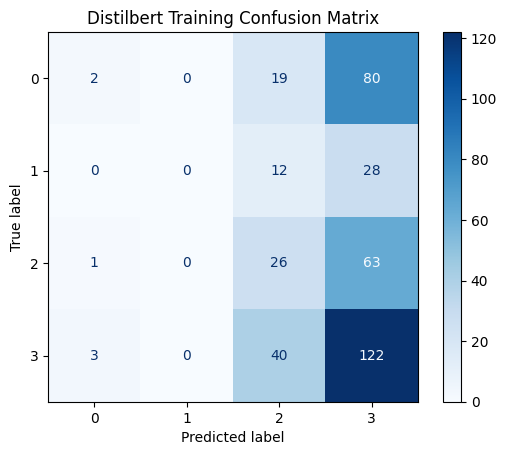

Distilbert Training Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.02      0.04       101
           1       0.00      0.00      0.00        40
           2       0.27      0.29      0.28        90
           3       0.42      0.74      0.53       165

    accuracy                           0.38       396
   macro avg       0.25      0.26      0.21       396
weighted avg       0.32      0.38      0.29       396

Distilbert Train loss: 1.3126, Distilbert Train accuracy: 0.3788


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


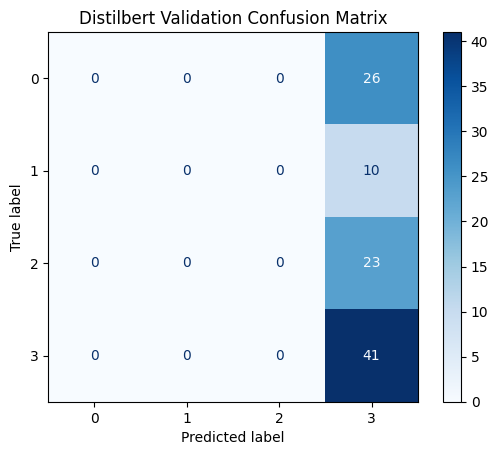

Distilbert Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        23
           3       0.41      1.00      0.58        41

    accuracy                           0.41       100
   macro avg       0.10      0.25      0.15       100
weighted avg       0.17      0.41      0.24       100

Distilbert Validation loss: 1.2788, Distilbert Validation accuracy: 0.4100
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


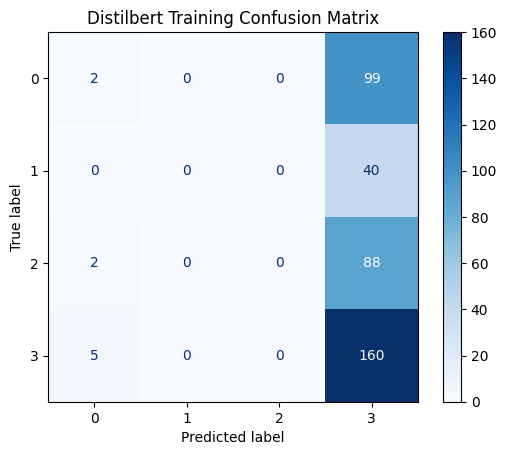

Distilbert Training Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.02      0.04       101
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        90
           3       0.41      0.97      0.58       165

    accuracy                           0.41       396
   macro avg       0.16      0.25      0.15       396
weighted avg       0.23      0.41      0.25       396

Distilbert Train loss: 1.2708, Distilbert Train accuracy: 0.4091


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


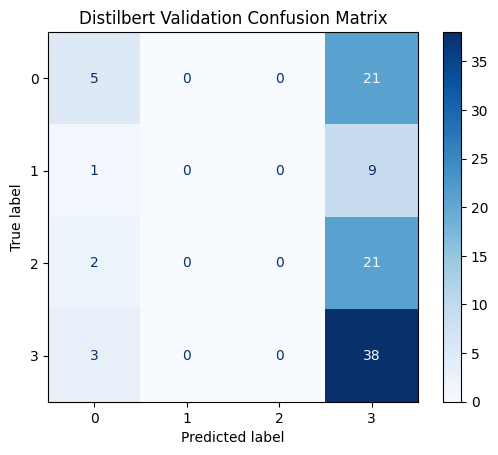

Distilbert Validation Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.19      0.27        26
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        23
           3       0.43      0.93      0.58        41

    accuracy                           0.43       100
   macro avg       0.22      0.28      0.21       100
weighted avg       0.29      0.43      0.31       100

Distilbert Validation loss: 1.2491, Distilbert Validation accuracy: 0.4300
Epoch 3/5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


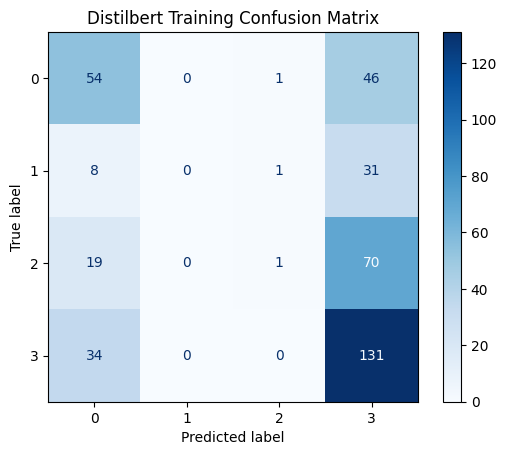

Distilbert Training Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.53      0.50       101
           1       0.00      0.00      0.00        40
           2       0.33      0.01      0.02        90
           3       0.47      0.79      0.59       165

    accuracy                           0.47       396
   macro avg       0.32      0.33      0.28       396
weighted avg       0.39      0.47      0.38       396

Distilbert Train loss: 1.2219, Distilbert Train accuracy: 0.4697


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


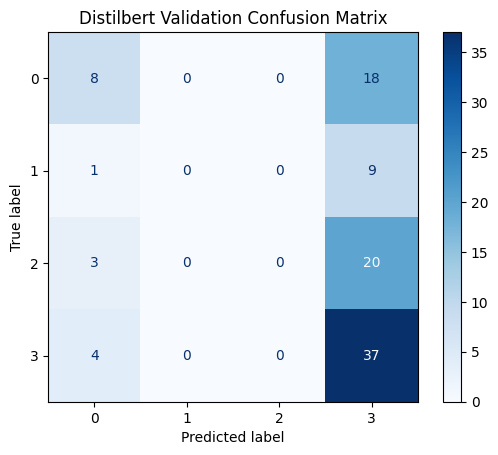

Distilbert Validation Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.31      0.38        26
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        23
           3       0.44      0.90      0.59        41

    accuracy                           0.45       100
   macro avg       0.24      0.30      0.24       100
weighted avg       0.31      0.45      0.34       100

Distilbert Validation loss: 1.2704, Distilbert Validation accuracy: 0.4500
Epoch 4/5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


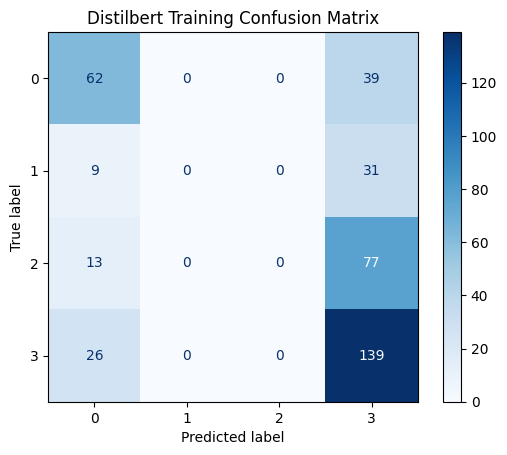

Distilbert Training Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.61      0.59       101
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        90
           3       0.49      0.84      0.62       165

    accuracy                           0.51       396
   macro avg       0.26      0.36      0.30       396
weighted avg       0.35      0.51      0.41       396

Distilbert Train loss: 1.1779, Distilbert Train accuracy: 0.5076


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


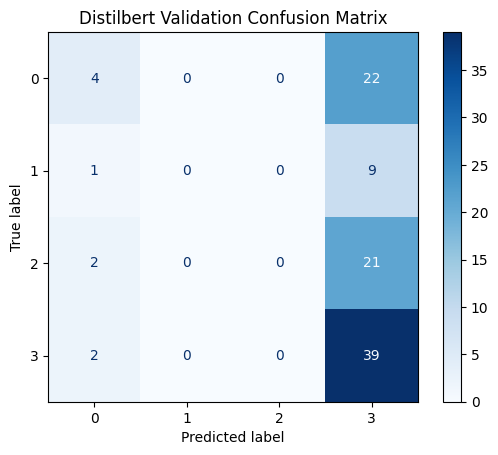

Distilbert Validation Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.15      0.23        26
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        23
           3       0.43      0.95      0.59        41

    accuracy                           0.43       100
   macro avg       0.22      0.28      0.20       100
weighted avg       0.29      0.43      0.30       100

Distilbert Validation loss: 1.2773, Distilbert Validation accuracy: 0.4300
Epoch 5/5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


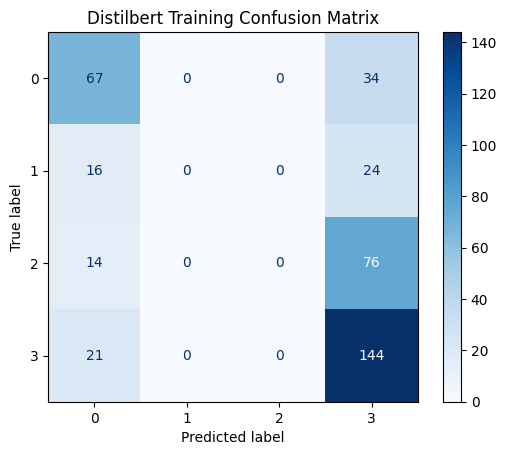

Distilbert Training Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.66      0.61       101
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        90
           3       0.52      0.87      0.65       165

    accuracy                           0.53       396
   macro avg       0.27      0.38      0.32       396
weighted avg       0.36      0.53      0.43       396

Distilbert Train loss: 1.1221, Distilbert Train accuracy: 0.5328


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


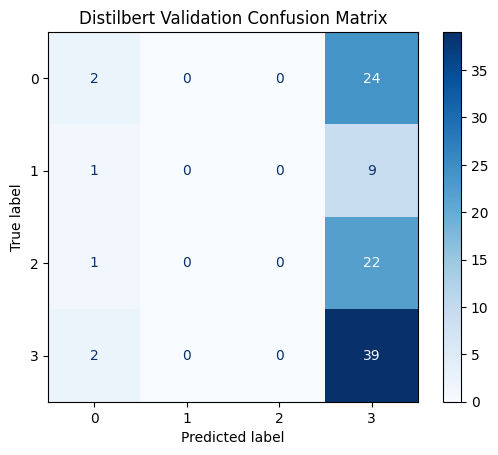

Distilbert Validation Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.08      0.12        26
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        23
           3       0.41      0.95      0.58        41

    accuracy                           0.41       100
   macro avg       0.19      0.26      0.18       100
weighted avg       0.26      0.41      0.27       100

Distilbert Validation loss: 1.3096, Distilbert Validation accuracy: 0.4100


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [82]:

# Move model to device (CPU for now)
device = torch.device("cpu")
model.to(device)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Train for one epoch
    train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn, device)
    print(f"Distilbert Train loss: {train_loss:.4f}, Distilbert Train accuracy: {train_accuracy:.4f}")

    # Evaluate on validation set
    val_loss, val_accuracy = evaluate(model, val_loader, loss_fn, device)
    print(f"Distilbert Validation loss: {val_loss:.4f}, Distilbert Validation accuracy: {val_accuracy:.4f}")


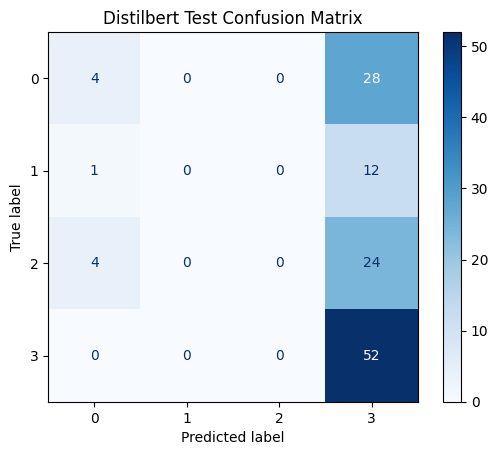

Distilbert Test Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.12      0.20        32
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        28
           3       0.45      1.00      0.62        52

    accuracy                           0.45       125
   macro avg       0.22      0.28      0.20       125
weighted avg       0.30      0.45      0.31       125

Distilbert Test loss: 1.3346, Distilbert Test accuracy: 0.4480


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [83]:
# Combined function to evaluate test set, compute loss, accuracy, confusion matrix, and classification report
def evaluate_and_plot(model, test_loader, loss_fn, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch in test_loader:
            # Move the data to the selected device (CPU or GPU)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            # Track total loss and accuracy
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=-1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

            # Store predictions and true labels for confusion matrix and classification report
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_samples

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Distilbert Test Confusion Matrix")
    plt.show()

    # Display classification report
    #print(f"Distilbert Test loss: {avg_loss:.4f}, Distilbert Test accuracy: {accuracy:.4f}")
    print("Distilbert Test Classification Report:")
    print(classification_report(all_labels, all_preds))
    return avg_loss, accuracy

# Call the function
test_loss, test_accuracy = evaluate_and_plot(model, test_loader, loss_fn, device)
print(f"Distilbert Test loss: {test_loss:.4f}, Distilbert Test accuracy: {test_accuracy:.4f}")
